In [1]:
import requests 
import pandas as pd

## Extract Johnson & Johnson Stock Data

In [15]:
api_key = 'your_alpha_vantage_api_key'
symbol = 'JNJ'
url =  f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}&outputsize=full'

response = requests.get(url)
jnj_stock_data = response.json()

#convert to dataframe 
jnj_df = pd.DataFrame(jnj_stock_data['Time Series (Daily)']).T
jnj_df.columns = ['open', 'high', 'low', 'close', 'volume']
jnj_df.index = pd.to_datetime(jnj_df.index) 
jnj_df = jnj_df.apply(pd.to_numeric)    
jnj_df.head()

,open,high,low,close,volume
2024-08-28,163.00,165.000,162.710,163.92,5187198
2024-08-27,163.50,164.035,162.160,162.95,4388728
2024-08-26,164.17,165.710,163.540,164.61,6870622
2024-08-23,162.50,164.220,161.695,164.13,7093429
2024-08-22,162.00,162.490,160.790,162.35,6552142


## Checking for Missing Values

In [16]:
#check for missing values 
#print(jnj_df)
print(jnj_df.isnull().sum())

open      0
high      0
low       0
close     0
volume    0
dtype: int64


## Transforming Data: Adding a moving average column

In [19]:
#adding a moving average column
jnj_df['moving_avg'] = jnj_df['close'].rolling(window=20, min_periods=1).mean()
jnj_df.head()

,open,high,low,close,volume,moving_avg
2024-08-28,163.00,165.000,162.710,163.92,5187198,163.920000
2024-08-27,163.50,164.035,162.160,162.95,4388728,163.435000
2024-08-26,164.17,165.710,163.540,164.61,6870622,163.826667
2024-08-23,162.50,164.220,161.695,164.13,7093429,163.902500
2024-08-22,162.00,162.490,160.790,162.35,6552142,163.592000


## Loading data into SQLite

In [20]:
from sqlalchemy import create_engine
import os

# Create a writable database path
home_dir = os.path.expanduser("~")
db_path = os.path.join(home_dir, 'jnj_stock.db')

# Set up the database engine
engine = create_engine(f'sqlite:///{db_path}', echo=True)

# Load data into SQLite
jnj_df.to_sql('jnj_stock', con=engine, if_exists='replace')


2024-08-29 12:43:33,850 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-08-29 12:43:33,929 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("jnj_stock")
2024-08-29 12:43:33,930 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-08-29 12:43:33,932 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("jnj_stock")
2024-08-29 12:43:33,950 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-08-29 12:43:33,951 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2024-08-29 12:43:33,952 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-08-29 12:43:33,954 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='view' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2024-08-29 12:43:33,955 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-08-29 12:43:33,957 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("jnj_stock")
2024-08-29 12:43:33,958 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-0

6246

## Analyze & Visulize: Stock prices & Moving Average

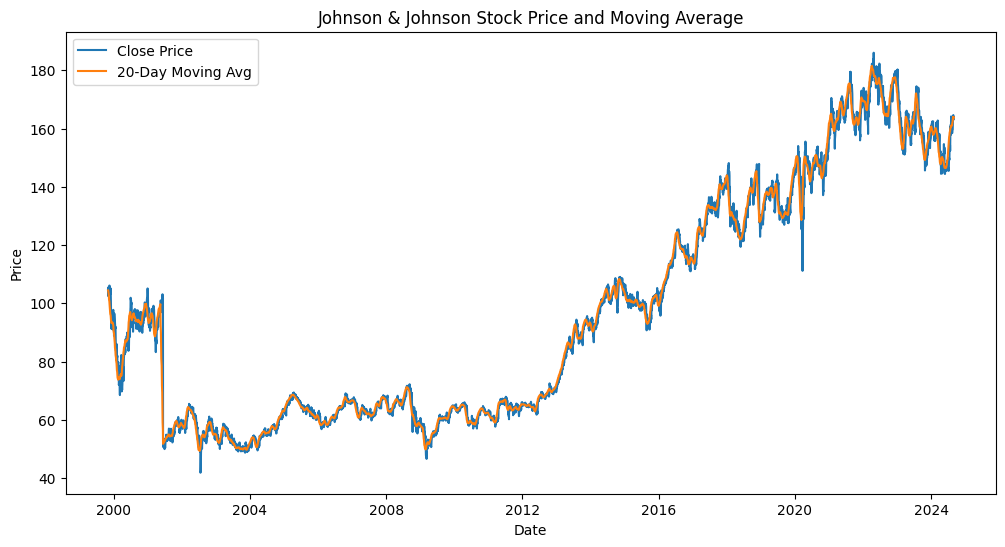

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=jnj_df, x=jnj_df.index, y='close', label='Close Price')
sns.lineplot(data=jnj_df, x=jnj_df.index, y='moving_avg', label='20-Day Moving Avg')
plt.title('Johnson & Johnson Stock Price and Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

* This chart shows the Johnson & Johnson stock price alongside the 20-day moving average over time. 



## Predictive Model

In [39]:
jnj_df['lag_1'] = jnj_df['close'].shift(1)
jnj_df['lag_2'] = jnj_df['close'].shift(2)

In [40]:
jnj_df['rolling_mean'] = jnj_df['close'].rolling(window=10).mean()
jnj_df['rolling_std'] = jnj_df['close'].rolling(window=10).std()

In [43]:
# X and y have the same number of samples
X = X[:len(y)]
y = y[:len(X)]

# training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)


In [44]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 0.7602099457459703
